# 0 Testing environment for Python

This is a testing environment, to elaborate methods and functions for the rersearch paper containing CCT computing resp. simulation.

## 0.1 Trying to reproduce a SMIB model

Testing / reproducing of a SMIB model after [Georg Kordowich](https://medium.com/@georg.kordowich/watts-up-with-dynamic-power-system-simulations-c0f16fc99769), therrefore using the already improved version with Heun's method for solving the numerical problem.
Supporting files and documentation can be found on [GitHub](https://github.com/georgkordowich/smib-simulation):

In [1]:
# some imports

from matplotlib import pyplot as plt
import numpy as np
import scipy as sp
from scipy.integrate import odeint

import simulation_gk as s

Defining all relavnt parameters and variables:

In [2]:
# Define the parameters of the system
fn = 60
H_gen = 3.5
X_gen = 0.2
X_ibb = 0.1
X_line = 0.65

# Values are initialized from loadflow
E_fd_gen = 1.075
E_fd_ibb = 1.033
P_m_gen = 1998/2200

# init states of variables
omega_gen_init = 0 # init state
delta_gen_init = np.deg2rad(45.9) # init state
delta_ibb_init = np.deg2rad(-5.0) # init state

# v_bb_gen_init = mag_and_angle_to_cmplx(1.0, np.deg2rad(36.172))

# -> How can these variables set globally in the Jupyter script or in the different modules?

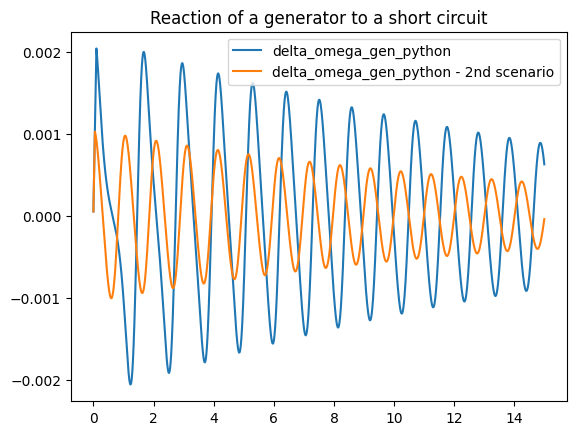

In [3]:
# execution of two different fault simulations; plotting them in time regime 
# In this example, the results are omega, delta, e_q_t, e_d_t, e_q_st, e_d_st of the generator and the IBB
fault_start = 0
fault_end = 0.1
sim_end = 15

t_sim, res_omega, res_delta, P_e = s.do_sim(fault_start, fault_end, sim_end)

# calculate for another fault-time

fault_start = 0
fault_end = 0.05

t_sim2, res_omega2, res_delta2, P_e2 = s.do_sim(fault_start, fault_end, sim_end)

# load the results from powerfactory for comparison
delta_omega_pf = np.loadtxt('simulation_example_gk/pictures/powerfactory_data.csv', skiprows=1, delimiter=',')


# Plot the results
plt.plot(t_sim, res_omega[:, 0].real/(2*np.pi), label='delta_omega_gen_python')
plt.plot(t_sim, res_omega2[:, 0].real/(2*np.pi), label='delta_omega_gen_python - 2nd scenario')
# plt.plot(delta_omega_pf[:, 0], delta_omega_pf[:, 1] - 1, label='delta_omega_gen_powerfactory')
plt.legend()

plt.title('Reaction of a generator to a short circuit')

plt.show()

In [4]:
# calculating the average mean error (absolute and relative) vs. powerfactory

# def error_abs(array1, array2):
#     # returning the cumulated, over a time period normalized, mean absolute error in rad
#     n_timesteps = np.size(array1)
#     error_cum = 0

#     for i in range(n_timesteps-1):
#         error_cum = error_cum + np.abs((array1[i] - 1) - array2[i])

#     error_abs = error_cum/n_timesteps
#     return error_abs

# def error_rel(array1, array2):
#     # returning the cumulated, over a time period normalized, mean relative error
#     n_timesteps = np.size(array1) # how many single errors; altought not working when size(array1) != size(array2)
#     error_cum = 0

#     # adding the singel errors up
#     for i in range(n_timesteps-1):
#         error_cum = error_cum + np.abs(1 - (array1[i] - 1)/array2[i])

#     error_rel = error_cum/n_timesteps
#     return error_rel

# print('abs error: ' + str(round(np.rad2deg(error_abs(delta_omega_pf[:, 1], res_omega[:, 0].real)), 6)) + ' grad')
# print('rel error: ' + str(round(error_rel(delta_omega_pf[:, 1], res_omega[:, 0].real)*100, 2)) + ' %')

# -> does it make more sense to have a look at the error in the first swing? Especially for transient stability analysis...

/var/folders/4h/hz1klhlj17v3cfnr51n7bmq80000gn/T/ipykernel_25005/879365142.py:55: RuntimeWarning: overflow encountered in exp
  return a*np.exp(-b*x) + c
/var/folders/4h/hz1klhlj17v3cfnr51n7bmq80000gn/T/ipykernel_25005/879365142.py:58: RuntimeWarning: overflow encountered in exp
  return -a*np.exp(-b*x) + c


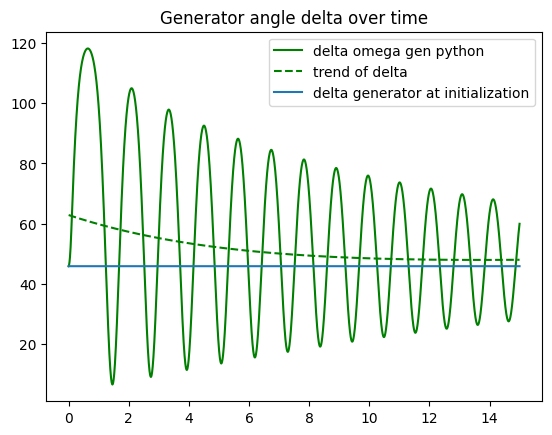

In [5]:
# plotting the absolut power generator angle in time regime with trendline fitting
# -> current solution not that good; better would be: Function for all maximas and minimas of sin-function -> difference between them would be the mean trend
# second scenario: bad fit; first scenario: good fit of trendline

from scipy import signal, optimize
from numpy import argwhere, sign
import matplotlib
import matplotlib.pyplot as plt

# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
# })

start_fit = 0
reshape_factor = int(sim_end/0.005 - start_fit)
fit_y = np.rad2deg(res_delta[start_fit:]).reshape(reshape_factor)
trend = np.polyfit(t_sim[start_fit:], fit_y, 2)
delta_trend = np.poly1d(trend)

fit_y2 = np.rad2deg(res_delta2[start_fit:]).reshape(reshape_factor)
trend2 = np.polyfit(t_sim[start_fit:], fit_y2, 1)
delta_trend2 = np.poly1d(trend2)

########################
# finding peaks and fitting them; difference = trendline
########################

def extreme_points(y):
    maxima_i, minima_i, maxima_x, maxima, minima_x, minima = [], [], [], [], [], []

    y_d = np.diff(y, prepend=0)

    for i in range(1, np.size(y)-1):
        if y_d[i-1] > 0 and y_d[i+1] < 0:
            # maxima -> vorher positiv, nachher negativ
            maxima_x.append(i*0.005)
            maxima_i.append(i)
            maxima.append(y[i])
        elif y_d[i-1] < 0 and y_d[i+1] > 0:
            # minima -> vorher negativ, nachher positiv
            minima_x.append(i*0.005)
            minima_i.append(i)
            minima.append(y[i])
    
    return maxima_i, maxima_x, maxima, minima_i, minima_x, minima

maxima_i, maxima_x, maxima, minima_i, minima_x, minima = extreme_points(res_delta[:,0])
maxima_i2, maxima_x2, maxima2, minima_i2, minima_x2, minima2 = extreme_points(res_delta2[:,0])

def exponential_fit_max(x, a, b, c):
    return a*np.exp(-b*x) + c

def exponential_fit_min(x, a, b, c):
    return -a*np.exp(-b*x) + c

def trendline(t, a, b, c, d, e, f):
    trendline = exponential_fit_min(t, d, e, f) + (exponential_fit_max(t, a, b, c) - exponential_fit_min(t, d, e, f))/2
    return trendline

# fitting of scenario 1
fitting_parameters_max, covariance = optimize.curve_fit(exponential_fit_max, maxima_x, np.rad2deg(maxima))
fitting_parameters_min, covariance = optimize.curve_fit(exponential_fit_min, minima_x, np.rad2deg(minima))
a, b, c = fitting_parameters_max
d, e, f = fitting_parameters_min

# fitting of scenario 2
# fitting_parameters_max2, covariance = optimize.curve_fit(exponential_fit_max, maxima_x2, np.rad2deg(maxima2))
# fitting_parameters_min2, covariance = optimize.curve_fit(exponential_fit_min, minima_x2, np.rad2deg(minima2))
# a2, b2, c2 = fitting_parameters_max2
# d2, e2, f2 = fitting_parameters_min2

delta_gen_init_array = np.rad2deg(delta_gen_init) * np.ones(np.size(t_sim))

########################
########################

plt.plot(t_sim[start_fit:], np.rad2deg(res_delta[start_fit:]), label='delta omega gen python', color='g')
# plt.plot(t_sim[start_fit:], np.rad2deg(res_delta2[start_fit:]), label='delta_omega_gen_python - 2nd scenario', color='orange')
plt.plot(t_sim, trendline(t_sim, a, b, c, d, e, f), label='trend of delta', ls='--', c='g')
plt.plot(t_sim, delta_gen_init_array, label='delta generator at initialization')
# plt.plot(t_sim, trendline(t_sim, a2, b2, c2, d2, e2, f2), label='trend of delta - 2nd scenario', ls='--', c='orange')

plt.legend()
plt.title('Generator angle delta over time')
# plt.savefig('gen_angle_trend.pgf')
plt.show()

## 0.2 Comparison to pythons solution

Solving the differential equation with Python build-in *odeint()* solvers. Comparing it to the others.

-> Possible?

In [6]:
# trying to solve the ODE with python build-in odeint or rungekutta

# P_e_max = P_m_gen / np.sin(delta_gen_init)

# def mag_and_angle_to_cmplx(mag, angle):
#     return mag * np.exp(1j * angle)

# def generator_swing(state, t, omega):
#     ddelta, domega = state

#     return [domega, 1 / (2 * H_gen) * (P_m_gen - P_e_max * np.sin(ddelta))]

# state0 = [delta_gen_init, omega_gen_init]

# sol_odeint = odeint(generator_swing, state0, t_sim)

# # plt.plot(t_sim, res_omega[:, 0].real, label='delta_omega_gen_python')
# plt.plot(t_sim, sol_odeint[:,0], label='delta_gen_odeint')
# plt.legend()
# plt.title('Comparison delta odeint vs. Heun')
# plt.show()

# plt.plot(t_sim, sol_odeint[:,1], label='omega_gen_odeint')
# plt.legend()
# plt.title('Comparison omega odeint vs. Heun')
# plt.show()

In [7]:
# solution of blackbox.ai with odeint

import numpy as np
from scipy.integrate import odeint

def mag_and_angle_to_cmplx(mag, angle):
    return mag * np.exp(1j * angle)

# Parameters
fault_start = 1
fault_end = 1.05

fn = 60
H_gen = 3.5
X_gen = 0.2
X_ibb = 0.1
X_line = 0.65

# Values are initialized from loadflow
E_fd_gen = 1.075
E_fd_ibb = 1.033
P_m_gen = 1998/2200

# init states of variables
omega_gen_init = 0 # init state
delta_gen_init = np.deg2rad(45.9) # init state
delta_ibb_init = np.deg2rad(-5.0) # init state

# Number of steps for output
t_final = 5
steps = 1000
P_e = []

# Define the ODE system
def ODE_system(state, t):
    # global H_gen
    omega, delta = state
    
    d_omega_dt = 1 / (2 * H_gen) * (T_m_gen(omega) - P_e_gen(delta, t))
    d_delta_dt = omega

    return [d_omega_dt, d_delta_dt]

# External functions for dependencies
def T_m_gen(omega):
    # Assuming a simple linear function for demonstration purposes
    return P_m_gen / (1 + omega)

def P_e_gen(delta, t):
    if fault_start <= t < fault_end: # sc_on = True
        y_adm = np.array([[(-1j / X_gen - 1j / X_line) + 1000000, 1j / X_line],[1j / X_line, -1j / X_line - 1j / X_ibb]])
    else: # sc_on = False
        y_adm = np.array([[-1j / X_gen - 1j / X_line, 1j / X_line],[1j / X_line, -1j / X_line - 1j / X_ibb]])

    # Calculate the inverse of the admittance matrix (Y^-1)
    y_inv = np.linalg.inv(y_adm)

    # Calculate current injections of the generator and the infinite busbar
    i_inj_gen = mag_and_angle_to_cmplx(E_fd_gen, delta) / (1j * X_gen)
    i_inj_ibb = mag_and_angle_to_cmplx(E_fd_ibb, delta_ibb_init) / (1j * X_ibb)

    # Calculate voltages at the bus by multiplying the inverse of the admittance matrix with the current injections
    v_bb_gen = y_inv[0, 0] * i_inj_gen + y_inv[0, 1] * i_inj_ibb
    v_bb_ibb = y_inv[1, 0] * i_inj_gen + y_inv[1, 1] * i_inj_ibb

    E_gen_cmplx = mag_and_angle_to_cmplx(E_fd_gen, delta)
    
    P_e = (v_bb_gen * np.conj((E_gen_cmplx - v_bb_gen) / (1j * X_gen))).real
    return P_e

# Time vector
t_sim = np.arange(0, t_final, 0.005)

# Initial conditions
initial_conditions = [omega_gen_init, delta_gen_init]

# Integrate the ODE system
solution = odeint(ODE_system, initial_conditions, t_sim).T

# Output
omega = solution[0, :]
delta = solution[1, :]

# print('The ODE system solution is:\n')
# print('t, omega, delta\n')
# for t, om, delt in zip(t, omega, delta):
#     print(f'{t}, {om}, {delt}')

plt.plot(t_sim, omega, label='omega')
plt.legend()
plt.title('Solution of Blackbox.ai - Omega with odeint')
plt.show()

plt.plot(t_sim, delta, label='delta')
plt.legend()
plt.title('Solution of Blackbox.ai - Delta with odeint')
plt.show()

## 0.3 Comparison to own (improved) solver

Implementing Runge-Kutta-Solver for the ODE problem.

# 1 CCT elaboration of synchronous generators

This jupyter notebook contains a single machine model for the simulation of a single synchronous generator.
With this notebook-type programming the readability and documentation of the model and thinking shall be improved in relation to a normal and standalone python script / program.

## 1.1 Computing the EAC for determing the CCT

Before we modelled the behavior of single synchronous machine against a fixed electrical bus (called SMIB model). Now we want to calculate the CCT from that and further determine if the machine is still running in stable operation.

### SMIB-Model

### EAC calculation

## 1.2 Using .csv-files as mini-storage

.csv-files shall be used as documentation / storage. Therefore functions shall be created to store datasets of CCT experiments.

File-Writing and Read-Out is observed necessary.

## 1.3 Plotting of results

Functions / A Library shall be created to easily create plots out of stored data.

Setup of: Plotting the electrical power against the angle $\delta$ of the generator combined with the steady turbine power. Thus showing acceleration and deceleration areas:

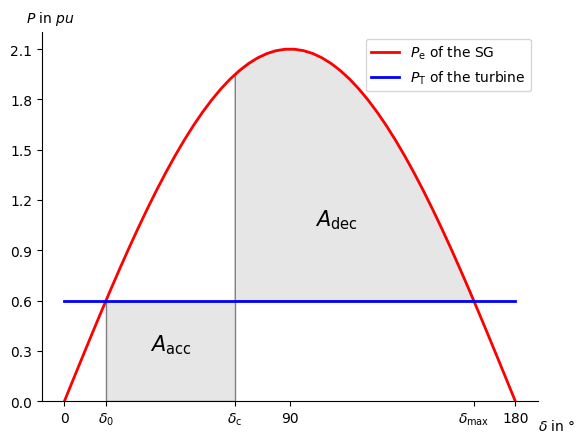

In [6]:
# plotting electrical power against power angle delta combined with the steady turbine power. Thus showing acceleration and deceleration areas

from matplotlib import pyplot as plt
import numpy as np
import scipy as sp
from matplotlib.patches import Polygon

# inputs:
P_m = 0.6
P_max = 2.1
delta_c = 68.01

# power functions
def P_e(x):
    # determing the P_e curve under input in degrees
    return P_max*np.sin(x*2*np.pi/360)

def P_t(x):
    return P_m*np.ones(np.size(x))

# Integral limits
delta_0 = np.arcsin(P_m/P_max)*360/(2*np.pi)
delta_max = 180-np.arcsin(P_m/P_max)*360/(2*np.pi)

# calculation of P_e and P_t
x = np.linspace(0, 180)
y1 = P_e(x)
y2 = P_t(x)

# setting up the plot and plotting P_e and P_t
fig, ax = plt.subplots()
ax.plot(x, y1, 'r', linewidth=2, label='$P_\mathrm{e}$ of the SG')
ax.plot(x, y2, 'b', linewidth=2, label='$P_\mathrm{T}$ of the turbine')
ax.set_ylim(bottom=0)

# Make the shaded region for area_acc
ix1 = np.linspace(delta_0, delta_c)
iy1 = P_t(ix1)
verts = [(delta_0, 0), *zip(ix1, iy1), (delta_c, 0)]
poly = Polygon(verts, facecolor='0.9', edgecolor='0.5')
ax.add_patch(poly)

# Make the shaded region for area_dec, https://matplotlib.org/stable/gallery/lines_bars_and_markers/fill_between_demo.html
ix2 = np.linspace(delta_c, delta_max)
iy2 = P_e(ix2)
ax.fill_between(ix2, iy2, P_m, facecolor='0.9', edgecolor='0.5')
# ax.vlines(x = delta_max, ymin = 0, ymax = P_m, colors = '0.5') # vertical line for marking delta_max

# adding area descriptions
ax.text(0.5*(delta_0 + delta_c), 0.5*(P_m), r"$A_\mathrm{acc}$", horizontalalignment='center', fontsize=15)
ax.text(0.47*(delta_max + delta_c), P_m+0.3*(P_max-P_m), r"$A_\mathrm{dec}$", horizontalalignment='center', fontsize=15)

# axis text and optical manipulation of the plot
fig.text(0.9, 0.05, '$\delta$ in $°$')
fig.text(0.1, 0.9, '$P$ in $pu$')

ax.spines[['top', 'right']].set_visible(False)
ax.set_xticks([0,90,180,delta_0, delta_c, delta_max], labels=[0,90,180,'$\delta_\mathrm{0}$', '$\delta_\mathrm{c}$', '$\delta_\mathrm{max}$'])
ax.set_yticks(np.arange(0, P_max, 0.3))

plt.legend()
plt.show()

Calculate the areas in the Plot before, comparing them and stating stability or instability.

In [4]:
# calculating the areas of the plot and accessing stable or unstable regime
def diff_func(x):
    return P_max*np.sin(x*2*np.pi/360) - P_m

area_acc = sp.integrate.quad(P_t, delta_0, delta_c)
area_dec = sp.integrate.quad(diff_func, delta_c, delta_max)

print('A_acc: ' + str(np.round(area_acc[0], 2)))
print('A_dec: ' + str(np.round(area_dec[0], 2)))

if area_acc[0] < area_dec[0]:
    print('-> stable')
else:
    print('-> NOT stable')

A_acc: 38.69
A_dec: 43.68
-> stable


Kimbark curve plot: $P_\mathrm{eq}$ vs. $\delta_\mathrm{eq}$ for accessing the critcal power generator angle:

Plot of power generator angle $\delta$ over time. Determing the CCT (critical clearing time) through this assessment:

# 2 Further investigation

## 2.1 Setting up of test cases

Test case scenarios (different observation boundaries / operation conditions) shall be created. On top a testing matrix for a small parameter testing is mandatory.

## 2.2 Inverse calculation (optimization)

Trying to implement an inverse calculation (operation conditions / boundaries -> minimal machine requirements), can be seen as "optimization".

# 3 Non-elaborated influences

- damping part in every machine
- machine networks and fault with large line distance to the generator(s); esp. with high-interconnected highest-voltage networks -> complex behaviors
- stability behavior of other generators and their influence on the examined machine